# Models
## Exploring and Predicting EV Registration Data

Daniel Gieseke | August 2023

The electric vehicle (EV) industry is booming at every level, and companies in the industry are aiming to understand the different factors that affect EV adoption, and the geographic spread of EVs such that they can adequately prepare and market themselves.  This project aims to take in real world data on EV registrations by zip code along with several socioeconomic factors to find respective variance and correlation, and ultimately build a machine learning model that can predict EV registration by zip code; with these models we aim to understand the factors that affect EV adoption.

**About this notebook**

This notebook contains the machine learning models developed in conjunction with this project.  For details on EDA and data preparation, please visit my other notebooks on GitHub.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid", {"font.family": "Helvetica"})
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.tree import plot_tree
from sklearn.metrics import ConfusionMatrixDisplay
from uszipcode import SearchEngine
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
import mpu
import zipcodes
import warnings
warnings.filterwarnings("ignore")

/Users/danielgieseke/anaconda3/envs/learn-env/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Importing EV Registration Data and Performing Light Cleaning

In [2]:
# Importing Data
df = pd.read_csv('Cleaned_EV_Reg_Data')

# Dropping Unneeded Row
df = df.drop(columns='Unnamed: 0')

# Converting ZIP Column to STR
df['ZIP Code'] = df['ZIP Code'].astype(str)

In [3]:
# Cleaning ZIP Column
dirty_zips = df['ZIP Code']
clean_zips = []

for code in dirty_zips:
    if len(code) < 5:
        new_code = '0' + code
        clean_zips.append(new_code)
    else:
        clean_zips.append(code)

df['ZIP Code'] = clean_zips

In [4]:
# Adding State Column
conditions = [
    df['NY'] == 1,
    df['NJ'] == 1,
    df['CT'] == 1,
]

outputs = [
    'New York', 'New Jersey', 'Connecticut'
]

In [5]:
df['State'] = np.select(conditions, outputs)

In [6]:
# Creating "TIME" df by Joining 2022 data
df_2022 = pd.read_csv('Cleaned_EV_Reg_Data_2022')

# Converting ZIP Column to STR
df_2022['ZIP Code'] = df_2022['ZIP Code'].astype(str)

# Cleaning ZIP Column
dirty_zips = df_2022['ZIP Code']
clean_zips = []

for code in dirty_zips:
    if len(code) < 5:
        new_code = '0' + code
        clean_zips.append(new_code)
    else:
        clean_zips.append(code)

df_2022['ZIP Code'] = clean_zips

df_time = df.merge(df_2022, on='ZIP Code', how='left')

In [7]:
# Removing Connecticut from TIME df as CT doesn't have a wide breadth of EV data from 2022
df_time = df_time.dropna()

## Model 1 - Predicting Total EVs Registered in a ZIP Code - Linear Regression

Below I am performing a linear regression using first a model from the Statsmodels.api library, then performing a train test split using the scikit-learn library.  After finding my best features in my model using my Statsmodels.api model, I continued to tune my model with scikit-learn.  Eventually I received an R2 score of .82.

### Statsmodels.api

In [8]:
y = df['Vehicle Count']
X = df[['Median Family Household Income', 'Population', 'Percent Pop. Bachelors Deg. - 35-44', 
            'high_pop', 'in_NYC', 'EV Charging Stations', 'CT', 
             'Percent Pop. Age 30-34', 'High_Income', 
           'Young_Liberal', 'Income_Liberal', 'Income_Pop', 'Ed_Income', 'NYC Suburb']]

In [9]:
model = sm.OLS(y, sm.add_constant(X))

In [10]:
results = model.fit()

In [11]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Vehicle Count   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     449.3
Date:                Tue, 01 Aug 2023   Prob (F-statistic):               0.00
Time:                        14:00:54   Log-Likelihood:                -14909.
No. Observations:                2614   AIC:                         2.985e+04
Df Residuals:                    2599   BIC:                         2.994e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                 -43.3983      6.914     -6.276      0.000     -56.957     -29.840
Median Family Household Income          0.0004   7.66e-05      4.958      0.000       0.000       0.001
Population                              0.0011      0.000      4.165      0.000       0.001       0.002
Percent Pop. Bachelors Deg. - 35-44     0.8249      0.094      8.820      0.000       0.642       1.008
high_pop                               55.0774      4.421     12.458      0.000      46.408      63.746
in_NYC                               -124.4403      6.962    -17.874      0.000    -138.092    -110.789
EV Charging Stations                    3.0404      0.511      5.951      0.000       2.039       4.042
CT                                    -14.5157      4.930     -2.944      0.003     -24.183      -4.848
Percent Pop. Age 30-34                 -2.6933      0.576     -4.672      0.000      -3.824      -1.563
High_Income                           -19.9554      8.829     -2.260      0.024     -37.269      -2.642
Young_Liberal                          -3.9102      0.590     -6.632      0.000      -5.066      -2.754
Income_Liberal                          0.0002   4.11e-05      5.752      0.000       0.000       0.000
Income_Pop                           3.551e-08   3.75e-09      9.459      0.000    2.81e-08    4.29e-08
Ed_Income                           -3.518e-08   2.32e-08     -1.514      0.130   -8.08e-08    1.04e-08
NYC Suburb                             15.8544      4.854      3.266      0.001       6.337      25.372
==============================================================================
Omnibus:                     1021.391   Durbin-Watson:                   1.297
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9416.124
Skew:                           1.590   Prob(JB):                         0.00
Kurtosis:                      11.738   Cond. No.                     1.73e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### scikit-learn

In [12]:
y = df['Vehicle Count']
X = df[['Median Family Household Income', 'Population', 'Percent Pop. Bachelors Deg. - 35-44', 
            'dist_NYC', 'high_pop', 'voted for joe', 'in_NYC', 'EV Charging Stations', 'CT', 
            'Percent Pop. Age 25-29', 'Percent Pop. Age 30-34', 'Percent Pop. Age 35-39', 'High_Income', 
           'Young_Liberal', 'Income_Liberal', 'Income_Pop', 'Ed_Income', 'NYC Suburb']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [13]:
ss = StandardScaler()

ss.fit(X_train)
X_standardized_train = ss.transform(X_train)
X_standardized_test = ss.transform(X_test)

In [14]:
lr_raw = LinearRegression()
lr_raw.fit(X_standardized_train, y_train)

# Below is the R2 of my model - as you can see, it is similar to my model built using "Statsmodels.api"
lr_raw.score(X_standardized_train, y_train)

0.7101230195375707

In [15]:
# Below are the coefficients of my scaled data - this tells me the most important features to my model
pd.Series(lr_raw.coef_, index = X.columns)

Median Family Household Income         19.088655
Population                             22.402650
Percent Pop. Bachelors Deg. - 35-44    21.390147
dist_NYC                                1.903036
high_pop                               25.661928
voted for joe                           0.285955
in_NYC                                -34.960138
EV Charging Stations                    7.879401
CT                                     -3.593818
Percent Pop. Age 25-29                 -3.071111
Percent Pop. Age 30-34                 -7.675295
Percent Pop. Age 35-39                  2.275639
High_Income                            -9.510257
Young_Liberal                         -12.249013
Income_Liberal                         11.799739
Income_Pop                             80.196031
Ed_Income                             -13.667277
NYC Suburb                              6.316243
dtype: float64

In [16]:
# Instantiating and Fitting a MinMaxScaler
scale = MinMaxScaler()
X_train_transformed = scale.fit_transform(X_train)
X_test_transformed = scale.transform(X_test)

In [17]:
# Instantiating a ridge, lasso and regular linear regression model  
# Note that in scikit-learn, the regularization parameter is denoted by alpha (and not lambda)
ridge = Ridge(alpha=0.5)
ridge.fit(X_train_transformed, y_train)

lasso = Lasso(alpha=0.5)
lasso.fit(X_train_transformed, y_train)

lin = LinearRegression()
lin.fit(X_train_transformed, y_train)

LinearRegression()

In [18]:
# Instantiating and Fitting Polynomial Features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

X_train_transformed = scale.fit_transform(X_train_poly)
X_test_transformed = scale.transform(X_test_poly)

# Fitting the models
ridge.fit(X_train_transformed, y_train)
lasso.fit(X_train_transformed, y_train)
lin.fit(X_train_transformed, y_train)

# Generating predictions
y_h_ridge_train = ridge.predict(X_train_transformed)
y_h_ridge_test = ridge.predict(X_test_transformed)
y_h_lasso_train = lasso.predict(X_train_transformed)
y_h_lasso_test = lasso.predict(X_test_transformed)
y_h_lin_train = lin.predict(X_train_transformed)
y_h_lin_test = lin.predict(X_test_transformed)

# Displaying results
print('Train Error Polynomial Ridge Model', mean_squared_error(y_train, y_h_ridge_train))
print('Test Error Polynomial Ridge Model', mean_squared_error(y_test, y_h_ridge_test))
print('\n')
print('Train Error Polynomial Lasso Model', mean_squared_error(y_train, y_h_lasso_train))
print('Test Error Polynomial Lasso Model', mean_squared_error(y_test, y_h_lasso_test))
print('\n')
print('Train Error Unpenalized Polynomial Model', mean_squared_error(y_train, y_h_lin_train))
print('Test Error Unpenalized Polynomial Model', mean_squared_error(y_test, y_h_lin_test))
print('\n')
print('Polynomial Ridge Parameter Coefficients:', len(ridge.coef_[ridge.coef_ != 0]), 
      'non-zero coefficient(s) and', len(ridge.coef_[ridge.coef_ == 0]), 'zeroed-out coefficient(s)')
print('Polynomial Lasso Parameter Coefficients:',  len(lasso.coef_[lasso.coef_ != 0]), 
      'non-zero coefficient(s) and', len(lasso.coef_[lasso.coef_ == 0]), 'zeroed-out coefficient(s)')
print('Polynomial Model Parameter Coefficients:',  len(lin.coef_[lin.coef_ != 0]), 
      'non-zero coefficient(s) and', len(lin.coef_[lin.coef_ == 0]), 'zeroed-out coefficient(s)')

Train Error Polynomial Ridge Model 2550.5898032423
Test Error Polynomial Ridge Model 3226.527419471121


Train Error Polynomial Lasso Model 3622.701240195662
Test Error Polynomial Lasso Model 3883.742875357562


Train Error Unpenalized Polynomial Model 2251.036859239178
Test Error Unpenalized Polynomial Model 3645.912937172126


Polynomial Ridge Parameter Coefficients: 187 non-zero coefficient(s) and 3 zeroed-out coefficient(s)
Polynomial Lasso Parameter Coefficients: 22 non-zero coefficient(s) and 168 zeroed-out coefficient(s)
Polynomial Model Parameter Coefficients: 190 non-zero coefficient(s) and 0 zeroed-out coefficient(s)


In [19]:
# Printing the R2 score for my Ridge Model with Polynomial features
r2 = r2_score(y_true = y_test, y_pred = y_h_ridge_test)
print(r2)

0.8219397854069759


In [20]:
# Printing the MAE for my Ridge Model with Polynomial features
mae = mean_absolute_error(y_test, y_h_ridge_test)
print(mae)

31.494699327022627


**Brief Summary of First Model**: After tuning this model several times using different methods, I was able to improve the R2 score of my model to .82 using a ridge model with polynomial features.

## Model 2 - Predicting EVs per Capita by ZIP Code - Categorical Classifier

This second model is a categorical classifier where, instead of predicting the total number of EV registrations in a zip code, I am predicting the number of EV registrations per capita (number of EVs per 100,000 people).  The target is separated into three categories: (1) if a zip code has a below-average number of EVs per 100k, (2) if a zip code has an above average number of EVs per 100k, and (3) if a zip code has a very high number of EVs per capita.  I determined these targets after analyzing the spread of my target variable below.

Median EVs per capita in Data Set: 606.3505135880629


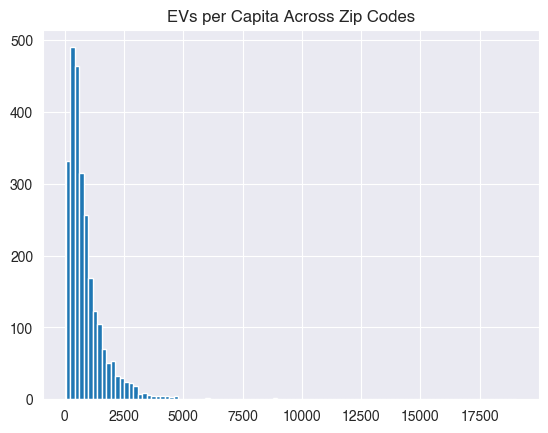

In [21]:
df['EVs per capita'].hist(bins=100).set(Title='EVs per Capita Across Zip Codes')
print("Median EVs per capita in Data Set:", df['EVs per capita'].median());

In [22]:
y = df['High EVs Per Capita']
X = df[['Median Family Household Income', 'Population', 'Percent Pop. Bachelors Deg. - 35-44', 
            'dist_NYC', 'high_pop', 'voted for joe', 'in_NYC', 'EV Charging Stations', 'NY', 'CT', 'High_Income', 
           'Young_Liberal', 'Income_Liberal', 'Income_Pop', 'Ed_Income', 'NYC Suburb']]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [24]:
# Build a pipeline with StandardScaler and RandomForestClassifier
scaled_pipeline_2 = Pipeline([('scaler', StandardScaler()), ('RF', RandomForestClassifier(random_state = 42))])

In [25]:
# Fit the training data to pipeline
scaled_pipeline_2.fit(X_train, y_train)

# Print the accuracy on test set
print("Accuracy Score of Training Data:", scaled_pipeline_2.score(X_train, y_train))
print("Accuracy Score of Test Data:", scaled_pipeline_2.score(X_test, y_test))

Accuracy Score of Training Data: 1.0
Accuracy Score of Test Data: 0.8089171974522293


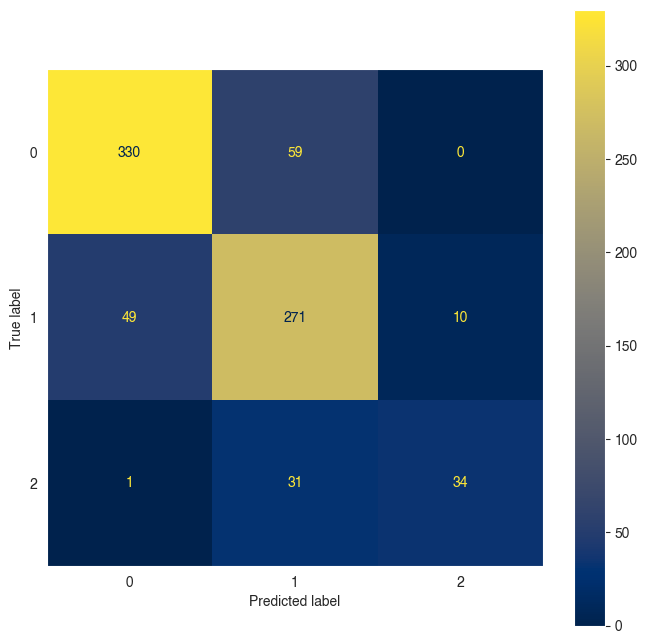

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
plt.grid(False)
ConfusionMatrixDisplay.from_estimator(scaled_pipeline_2, X_test, y_test, ax=ax, cmap="cividis");

In [27]:
# Finding Feature Importance from Our Random Forest Model
importances = scaled_pipeline_2.named_steps['RF'].feature_importances_

# Creating List of Tuples with Feature Names and Importances
feature_importances = [(feature, importance) for feature, importance in zip(X.columns, importances)]
feature_importances

[('Median Family Household Income', 0.20642528703808735),
 ('Population', 0.09235287517595413),
 ('Percent Pop. Bachelors Deg. - 35-44', 0.17540072321157374),
 ('dist_NYC', 0.09937218819082277),
 ('high_pop', 0.0074307076318807395),
 ('voted for joe', 0.006824299989202888),
 ('in_NYC', 0.02098860425306901),
 ('EV Charging Stations', 0.028353097540015488),
 ('NY', 0.013718195800866107),
 ('CT', 0.0052916085869727045),
 ('High_Income', 0.012766875015535507),
 ('Young_Liberal', 0.05141155902133118),
 ('Income_Liberal', 0.10008011413325027),
 ('Income_Pop', 0.08150967307847817),
 ('Ed_Income', 0.07951325473727516),
 ('NYC Suburb', 0.018560936595684745)]

## Model 3 - Predicting Rise EVs per Capita by ZIP Code in 2022 - Linear Regression

My last model predicts the rise of EVs Added by ZIP code in 2022.  Historically there has been a trend of early adoption of EVs by wealthier individuals, by limiting this target to EV adoption in 2022, we are aiming to see if median family household income is still the most important factor that leads to EV adoption, or if other factors are now at play.

**Note**: The goal of this model is not to receive a high R2, but to understand how the features used in my main linear regression model differ in terms of signficance and importance with my model on EVs Added in 2022.  The goal is to see if the factors that have historically impacted EV adoption were the same in 2022.

In [28]:
df_time['EVs Added in 2022'] = df_time['Vehicle Count_x'] - df_time['Vehicle Count_y']

In [29]:
y = df_time['EVs Added in 2022']
X = df_time[['Median Family Household Income', 'Population', 'Percent Pop. Bachelors Deg. - 35-44', 
            'dist_NYC', 'high_pop', 'voted for joe', 'in_NYC', 'EV Charging Stations',
            'Percent Pop. Age 25-29', 'Percent Pop. Age 30-34', 'Percent Pop. Age 35-39', 'High_Income', 
           'Young_Liberal', 'Income_Liberal', 'Income_Pop', 'Ed_Income', 'NYC Suburb']]

In [30]:
model = sm.OLS(y, sm.add_constant(X))

In [31]:
results = model.fit()

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      EVs Added in 2022   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     240.6
Date:                Tue, 01 Aug 2023   Prob (F-statistic):               0.00
Time:                        14:00:55   Log-Likelihood:                -13454.
No. Observations:                2862   AIC:                         2.694e+04
Df Residuals:                    2844   BIC:                         2.705e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -9.3794      4.153     -2.259      0.024     -17.522      -1.237
Median Family Household Income       8.387e-05   3.21e-05      2.613      0.009    2.09e-05       0.000
Population                              0.0006   8.76e-05      6.940      0.000       0.000       0.001
Percent Pop. Bachelors Deg. - 35-44     0.3289      0.035      9.490      0.000       0.261       0.397
dist_NYC                               -0.0144      0.005     -3.102      0.002      -0.024      -0.005
high_pop                               14.6475      1.537      9.531      0.000      11.634      17.661
voted for joe                           3.2915      4.202      0.783      0.433      -4.948      11.531
in_NYC                                -35.9370      2.340    -15.356      0.000     -40.526     -31.348
EV Charging Stations                    0.5488      0.149      3.684      0.000       0.257       0.841
Percent Pop. Age 25-29                 -0.4318      0.283     -1.525      0.127      -0.987       0.123
Percent Pop. Age 30-34                 -0.9122      0.211     -4.320      0.000      -1.326      -0.498
Percent Pop. Age 35-39                  0.3256      0.220      1.478      0.140      -0.106       0.757
High_Income                           -16.3217      3.154     -5.174      0.000     -22.507     -10.137
Young_Liberal                          -1.2457      0.367     -3.390      0.001      -1.966      -0.525
Income_Liberal                       6.555e-05   3.01e-05      2.181      0.029    6.63e-06       0.000
Income_Pop                           6.441e-09   1.18e-09      5.446      0.000    4.12e-09    8.76e-09
Ed_Income                           -4.434e-09   7.28e-09     -0.609      0.543   -1.87e-08    9.85e-09
NYC Suburb                              1.4941      1.650      0.905      0.365      -1.741       4.730
==============================================================================
Omnibus:                     1895.946   Durbin-Watson:                   0.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52143.270
Skew:                           2.719   Prob(JB):                         0.00
Kurtosis:                      23.191   Cond. No.                     3.09e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [34]:
ss = StandardScaler()

ss.fit(X_train)
X_standardized_train = ss.transform(X_train)
X_standardized_test = ss.transform(X_test)

In [35]:
lr_raw = LinearRegression()
lr_raw.fit(X_standardized_train, y_train)
lr_raw.score(X_standardized_train, y_train)

0.5855071957165068

In [36]:
pd.Series(lr_raw.coef_, index = X.columns)

Median Family Household Income          4.655399
Population                             13.620309
Percent Pop. Bachelors Deg. - 35-44     7.155934
dist_NYC                               -1.679538
high_pop                                6.834764
voted for joe                           0.917543
in_NYC                                -10.214834
EV Charging Stations                    2.485814
Percent Pop. Age 25-29                 -1.548359
Percent Pop. Age 30-34                 -2.352228
Percent Pop. Age 35-39                  1.102323
High_Income                            -3.571138
Young_Liberal                          -4.924282
Income_Liberal                          5.042764
Income_Pop                             13.964499
Ed_Income                              -1.613094
NYC Suburb                              0.144795
dtype: float64

## Summary - Comparing Model 1 and Model 3

It's important to note the difference in the importance of each scaled coefficient in Model 1 compared against Model 3.  Model 1 highlights the socioeconomic features that affect the total number of EVs currently in a ZIP code from the inception of EVs to present, whereas Model 3 highlights those that affected the growth of EVs in a ZIP code in 2022.  The smaller R2 and limited size of the coefficients in Model 3 using the same features tells us that income is no longer a leading factor in the adoption of EVs.  As we would assume with a contemporary internal combustion engine (ICE) vehicle, the population of a zip code is now the factor that most affects EV adoption.  Though this is difficult to interpret, we may be able to suggest that EV adoption is beginning to become more equitable, and not limited to a small number of demographics.